In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression

from datetime import datetime
from sklearn.externals import joblib

from sklearn.model_selection import GridSearchCV

<h3> 3.3 Cleaning and preprocessing of Questions </h3>

<h3> 3.3.1 Preprocessing </h3>

<ol> 
    <li> Sample 1M data points </li>
    <li> Separate out code-snippets from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

In [2]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [3]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


<h1>4. Machine Learning Models </h1>

<h2> 4.1 Converting tags for multilabel problems </h2>

<table>
<tr>
<th>X</th><th>y1</th><th>y2</th><th>y3</th><th>y4</th>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>1</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>1</td><td>0</td><td>0</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>0</td><td>0</td>
</tr>
</table>

<h2> 4.5 Modeling with less data points (0.5M data points) and more weight to title and 500 tags only. </h2>

In [4]:
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Titlemoreweight.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [5]:
# http://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table

read_db = 'train_no_dup.db'
write_db = 'Titlemoreweight.db'
train_datasize = 400000
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        # for selecting first 0.5M rows
        reader.execute("SELECT Title, Body, Tags From no_dup_train LIMIT 500001;")
        # for selecting random points
        #reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 500001;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")

Tables in the databse:
QuestionsProcessed
Cleared All the rows


<h3> 4.5.1 Preprocessing of questions </h3>

<ol> 
    <li> Separate Code from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> <b> Give more weightage to title : Add title three times to the question </b> </li>
   
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

In [6]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:
    
    is_code = 0
    
    title, question, tags = row[0], row[1], str(row[2])
    
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x
    
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))
    
    title=title.encode('utf-8')
    
    # adding title three time to the data to increase its weight
    # add tags string to the training data
    
    question=str(title)+" "+str(title)+" "+str(title)+" "+question
    
#     if questions_proccesed<=train_datasize:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question+" "+str(tags)
#     else:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question

    question=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question)
    words=word_tokenize(str(question.lower()))
    
    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
number of questions completed= 500000
Avg. length of questions(Title+Body) before processing: 1239
Avg. length of questions(Title+Body) after processing: 424
Percent of questions containing code: 57
Time taken to run this cell : 0:14:13.702826


In [7]:
# never forget to close the conections or else we will end up with database locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

__ Sample quesitons after preprocessing of data __

In [8]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('dynam datagrid bind silverlight dynam datagrid bind silverlight dynam datagrid bind silverlight bind datagrid dynam code wrote code debug code block seem bind correct grid come column form come grid column although necessari bind nthank repli advance..',)
----------------------------------------------------------------------------------------------------
('java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid follow guid link instal jstl got follow error tri launch jsp page java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid taglib declar instal jstl 1.1 tomcat webapp tri project work also tri version 1.2 jstl still messag caus solv',)
----------------------------------------------------------------------------------------------------
('java.sql.sqlexcept microsoft odbc driver

__ Saving Preprocessed data to a Database __

In [9]:
#Taking 0.5 Million entries to a dataframe.
write_db = 'Titlemoreweight.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [10]:
preprocessed_data.head()

,question,tags
0,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding
1,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding columns
2,java.lang.noclassdeffounderror javax servlet j...,jsp jstl
3,java.sql.sqlexcept microsoft odbc driver manag...,java jdbc
4,better way updat feed fb php sdk better way up...,facebook api facebook-php-sdk


In [11]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 500000
number of dimensions : 2


__ Converting string Tags to multilable output variables __ 

In [12]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

__ Selecting 500 Tags __

In [13]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [14]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

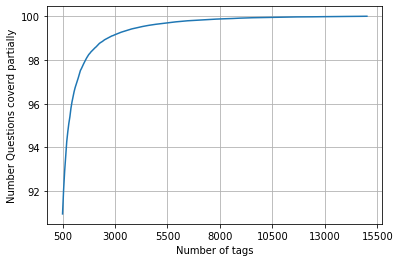

with  5500 tags we are covering  99.157 % of questions
with  500 tags we are covering  90.956 % of questions


In [15]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [16]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 45221 out of  500000


In [17]:
x_train=preprocessed_data.head(train_datasize)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - 400000)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:preprocessed_data.shape[0],:]

In [18]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (400000, 500)
Number of data points in test data : (100000, 500)


<h3> 4.5.2 Featurizing data with TfIdf vectorizer </h3>

In [23]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)



Time taken to run this cell : 0:02:51.543164


In [24]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (400000, 94928) Y : (400000, 500)
Dimensions of test data X: (99998, 94928) Y: (99998, 500)


<h3> 4.5.3 Applying Logistic Regression with OneVsRest Classifier </h3>

In [25]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.23705474109482189
Hamming loss  0.0027796155923118463
Micro-average quality numbers
Precision: 0.7220, Recall: 0.3258, F1-measure: 0.4490
Macro-average quality numbers
Precision: 0.5483, Recall: 0.2582, F1-measure: 0.3350
              precision    recall  f1-score   support

           0       0.94      0.64      0.76      5519
           1       0.69      0.26      0.37      8189
           2       0.81      0.37      0.51      6529
           3       0.81      0.43      0.56      3231
           4       0.81      0.41      0.54      6430
           5       0.81      0.34      0.48      2878
           6       0.87      0.49      0.63      5086
           7       0.88      0.54      0.67      4533
           8       0.60      0.13      0.21      3000
           9       0.81      0.53      0.64      2765
          10       0.59      0.16      0.25      3051
          11       0.70      0.33      0.45      3009
          12       0.65      0.25      0.36      2630
        

In [28]:
joblib.dump(classifier, 'lr_with_more_title_weight.pkl') 

['lr_with_more_title_weight.pkl']

In [29]:
start = datetime.now()
classifier_2 = OneVsRestClassifier(LogisticRegression(penalty='l1'), n_jobs=-1)
classifier_2.fit(x_train_multilabel, y_train)
predictions_2 = classifier_2.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions_2))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_2))


precision = precision_score(y_test, predictions_2, average='micro')
recall = recall_score(y_test, predictions_2, average='micro')
f1 = f1_score(y_test, predictions_2, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_2, average='macro')
recall = recall_score(y_test, predictions_2, average='macro')
f1 = f1_score(y_test, predictions_2, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_2))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.251065021300426
Hamming loss  0.0027028740574811497
Micro-average quality numbers
Precision: 0.7172, Recall: 0.3673, F1-measure: 0.4858
Macro-average quality numbers
Precision: 0.5571, Recall: 0.2951, F1-measure: 0.3711
              precision    recall  f1-score   support

           0       0.94      0.72      0.82      5519
           1       0.70      0.34      0.45      8189
           2       0.80      0.42      0.55      6529
           3       0.82      0.49      0.61      3231
           4       0.80      0.44      0.57      6430
           5       0.82      0.38      0.52      2878
           6       0.86      0.53      0.66      5086
           7       0.87      0.58      0.70      4533
           8       0.60      0.13      0.22      3000
           9       0.82      0.57      0.67      2765
          10       0.60      0.20      0.30      3051
          11       0.68      0.38      0.49      3009
          12       0.62      0.29      0.40      2630
          

## 1. Use bag of words upto 4 grams

In [19]:
vectorizer_bow = CountVectorizer(min_df=0.00009, ngram_range=(1,4), max_features=200000)
vectorizer_bow.fit(x_train['question'].values) # fit has to happen only on train data

X_train_bow = vectorizer_bow.transform(x_train['question'].values)
X_test_bow = vectorizer_bow.transform(x_test['question'].values)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)

After vectorizations
(400000, 99057) (400000, 500)
(100000, 99057) (100000, 500)


In [ ]:
#Saving bows
'''from sklearn.externals import joblib
#data points with 0.5 million data 
joblib.dump(X_train_bow, 'X_train_bow.pkl') 
joblib.dump(X_test_bow, 'X_test_bow.pkl')

#target class i.e multilabel classes with 0.5 million 
joblib.dump(y_train, 'y_train.pkl')
joblib.dump(y_test, 'y_test.pkl')'''

In [2]:
from sklearn.externals import joblib
X_train_bow = joblib.load('X_train_bow.pkl')
X_test_bow = joblib.load('X_test_bow.pkl')
y_train = joblib.load('y_train.pkl')
y_test = joblib.load('y_test.pkl')

In [3]:
print(X_train_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)

(400000, 99057) (400000, 500)
(100000, 99057) (100000, 500)


## 2. Perform hyperparameter tuning for Logistic regression using GridSearch

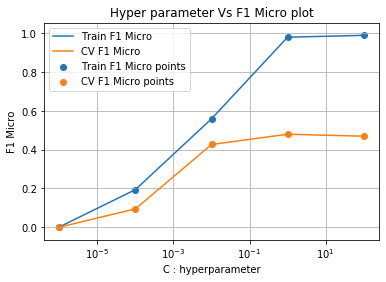

Time taken to run this cell : 3:33:54.567605


In [20]:
start = datetime.now()
parameters = {'estimator__C' : [1e-06, 1e-04, 1e-02, 1, 100]}
ovr = OneVsRestClassifier(LogisticRegression())
clf = GridSearchCV(ovr, parameters, cv=2, scoring='f1_micro', return_train_score=True,  n_jobs = -1)
clf.fit(X_train_bow, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_estimator__C'])

train_f1_micro= results['mean_train_score']
train_f1_micro_std= results['std_train_score']
cv_f1_micro = results['mean_test_score'] 
cv_f1_micro_std= results['std_test_score']
K =  results['param_estimator__C']
              
plt.plot(K, train_f1_micro, label='Train F1 Micro')
plt.plot(K, cv_f1_micro, label='CV F1 Micro')
plt.scatter(K, train_f1_micro, label='Train F1 Micro points')
plt.scatter(K, cv_f1_micro, label='CV F1 Micro points')
plt.legend()
plt.xlabel("C : hyperparameter")
plt.xscale('log')
plt.ylabel("F1 Micro")
plt.title("Hyper parameter Vs F1 Micro plot")
plt.grid()
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

## Compute the micro f1 score with Logistic regression(OvR)

In [10]:
classifier_2 = OneVsRestClassifier(LogisticRegression(C = 0.01), n_jobs=-1)
classifier_2.fit(X_train_bow, y_train)
predictions_2 = classifier_2.predict(X_test_bow)
print("Accuracy :",metrics.accuracy_score(y_test, predictions_2))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_2))


precision = precision_score(y_test, predictions_2, average='micro')
recall = recall_score(y_test, predictions_2, average='micro')
f1 = f1_score(y_test, predictions_2, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_2, average='macro')
recall = recall_score(y_test, predictions_2, average='macro')
f1 = f1_score(y_test, predictions_2, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_2))

Accuracy : 0.22664
Hamming loss  0.002867
Micro-average quality numbers
Precision: 0.6875, Recall: 0.3214, F1-measure: 0.4380
Macro-average quality numbers
Precision: 0.5218, Recall: 0.2441, F1-measure: 0.3219
              precision    recall  f1-score   support

           0       0.95      0.67      0.78      5519
           1       0.56      0.35      0.43      8190
           2       0.80      0.34      0.48      6529
           3       0.66      0.39      0.49      3231
           4       0.80      0.41      0.55      6430
           5       0.80      0.36      0.50      2879
           6       0.86      0.50      0.63      5086
           7       0.86      0.56      0.68      4533
           8       0.54      0.14      0.23      3000
           9       0.82      0.55      0.66      2765
          10       0.60      0.17      0.27      3051
          11       0.70      0.34      0.46      3009
          12       0.62      0.25      0.36      2630
          13       0.57      0.18

## Hyperparameter tuning Linear-SVM (SGDClassifier with loss-hinge)

In [24]:
parameters = {'estimator__alpha' : [1e-06, 1e-04, 1e-02, 1, 100]}
ovr = OneVsRestClassifier(SGDClassifier(loss='hinge'))
clf = GridSearchCV(ovr, parameters, cv=2, scoring='f1_micro', return_train_score=True,  n_jobs = -1)
clf.fit(X_train_bow, y_train)

results_2 = pd.DataFrame.from_dict(clf.cv_results_)
results_2 = results.sort_values(['param_estimator__alpha'])

train_f1_micro= results_2['mean_train_score']
train_f1_micro_std= results_2['std_train_score']
cv_f1_micro = results_2['mean_test_score'] 
cv_f1_micro_std= results_2['std_test_score']
K =  results_2['param_estimator__alpha']

plt.plot(K, train_f1_micro, label='Train F1 Micro')
plt.plot(K, cv_f1_micro, label='CV F1 Micro')
plt.scatter(K, train_f1_micro, label='Train F1 Micro points')
plt.scatter(K, cv_f1_micro, label='CV F1 Micro points')
plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.xscale('log')
plt.ylabel("F1 Micro")
plt.title("Hyper parameter Vs F1 Micro plot")
plt.grid()
plt.show()

KeyError: 'param_estimator__alpha'

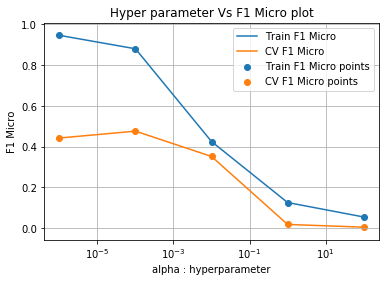

In [36]:
results_2 = results_2.sort_values(['param_estimator__alpha'])

train_f1_micro= results_2['mean_train_score']
train_f1_micro_std= results_2['std_train_score']
cv_f1_micro = results_2['mean_test_score'] 
cv_f1_micro_std= results_2['std_test_score']
K =  results_2['param_estimator__alpha']

plt.plot(K, train_f1_micro, label='Train F1 Micro')
plt.plot(K, cv_f1_micro, label='CV F1 Micro')
plt.scatter(K, train_f1_micro, label='Train F1 Micro points')
plt.scatter(K, cv_f1_micro, label='CV F1 Micro points')
plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.xscale('log')
plt.ylabel("F1 Micro")
plt.title("Hyper parameter Vs F1 Micro plot")
plt.grid()
plt.show()

## 3. Try OneVsRestClassifier  with Linear-SVM (SGDClassifier with loss-hinge)

In [9]:
classifier = OneVsRestClassifier(SGDClassifier(loss = 'hinge', alpha = 0.01), n_jobs=-1)
classifier.fit(X_train_bow, y_train)
predictions = classifier.predict (X_test_bow)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))

Accuracy : 0.20205
Hamming loss  0.00294848
Micro-average quality numbers
Precision: 0.7831, Recall: 0.2100, F1-measure: 0.3312
Macro-average quality numbers
Precision: 0.4435, Recall: 0.1134, F1-measure: 0.1617
              precision    recall  f1-score   support

           0       0.96      0.56      0.71      5519
           1       0.64      0.09      0.15      8190
           2       0.83      0.30      0.44      6529
           3       0.79      0.23      0.36      3231
           4       0.87      0.35      0.49      6430
           5       0.81      0.31      0.45      2879
           6       0.88      0.48      0.62      5086
           7       0.90      0.50      0.64      4533
           8       0.52      0.15      0.23      3000
           9       0.83      0.50      0.62      2765
          10       0.69      0.05      0.09      3051
          11       0.83      0.26      0.40      3009
          12       0.69      0.19      0.29      2630
          13       0.74      0.

## Conclusion

In [13]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Vectorizer", "Model", "Hyper Parameters", "Precision", 'F1-Micro']
table.add_row(['TFIDF', 'Logestic Regression (SGD)', 'Alpha = 0.00001', 0.7220, 0.490])
table.add_row(['TFIDF', 'Logestic Regression', 'C =  1', 0.7172, 0.4858])
table.add_row(['','','','',''])
table.add_row(['BOW', 'Logestic Regression', 'C = 0.01', 0.6875, 0.4380])
table.add_row(['BOW', 'Linear SVM (SGD)', 'Alpha =  0.01', 0.7831, 0.3312])
print(table)

+------------+---------------------------+------------------+-----------+----------+
| Vectorizer |           Model           | Hyper Parameters | Precision | F1-Micro |
+------------+---------------------------+------------------+-----------+----------+
|   TFIDF    | Logestic Regression (SGD) | Alpha = 0.00001  |   0.722   |   0.49   |
|   TFIDF    |    Logestic Regression    |      C =  1      |   0.7172  |  0.4858  |
|            |                           |                  |           |          |
|    BOW     |    Logestic Regression    |     C = 0.01     |   0.6875  |  0.438   |
|    BOW     |      Linear SVM (SGD)     |  Alpha =  0.01   |   0.7831  |  0.3312  |
+------------+---------------------------+------------------+-----------+----------+


# Summary
* Used 0.5 Million data points and Top 500 Tags
* As the dataset is large, performed 2 folds cross validation using GridSearchCV
* The best model obtained is Linear SVM with Alpha = 0.01
* BOW vectorizer on Linear SVM gave the best Precision of 78.31
* Precision was improved from 72.2 to 78.31